# Digit classifier

This notebook implements a digit classifier of 3's and 7's using different methodologies.

In [1]:
from fastai.data.external import untar_data, URLs

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
import numpy as np
import pandas as pd
import torch

from fastai.vision.all import Image


threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()

img_path = threes[0]
img = Image.open(img_path)
img_t = torch.tensor(np.array(img))
img_df = pd.DataFrame(img_t[2:26, 4:21])
display(img, np.array(img)[10:20, 10:20], img_t[10:20, 10:20], img_df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys'))

array([[  0,   0,   0,  24, 209, 254, 254, 254, 171,   0],
       [  0,   0,  91, 137, 253, 254, 254, 254, 112,   0],
       [ 40, 214, 250, 254, 254, 254, 254, 254,  34,   0],
       [ 81, 247, 254, 254, 254, 254, 254, 254, 146,   0],
       [  0, 110, 246, 254, 254, 254, 254, 254, 171,   0],
       [  0,   0,  73,  89,  89,  93, 240, 254, 171,   0],
       [  0,   0,   0,   0,   0,   1, 128, 254, 219,  31],
       [  0,   0,   0,   0,   0,   7, 254, 254, 214,  28],
       [  0,   0,   0,   0,   0, 138, 254, 254, 116,   0],
       [  0,   0,   0,   0,  25, 240, 254, 254,  34,   0]], dtype=uint8)

tensor([[  0,   0,   0,  24, 209, 254, 254, 254, 171,   0],
        [  0,   0,  91, 137, 253, 254, 254, 254, 112,   0],
        [ 40, 214, 250, 254, 254, 254, 254, 254,  34,   0],
        [ 81, 247, 254, 254, 254, 254, 254, 254, 146,   0],
        [  0, 110, 246, 254, 254, 254, 254, 254, 171,   0],
        [  0,   0,  73,  89,  89,  93, 240, 254, 171,   0],
        [  0,   0,   0,   0,   0,   1, 128, 254, 219,  31],
        [  0,   0,   0,   0,   0,   7, 254, 254, 214,  28],
        [  0,   0,   0,   0,   0, 138, 254, 254, 116,   0],
        [  0,   0,   0,   0,  25, 240, 254, 254,  34,   0]], dtype=torch.uint8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0
3,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0
4,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0
5,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0
6,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0
7,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0
8,0,0,0,0,0,0,0,0,0,24,209,254,254,254,171,0,0
9,0,0,0,0,0,0,0,0,91,137,253,254,254,254,112,0,0


## Pixel similarity

A nice first baseline. Compute the average of every pixel position for all images for each group (3's and 7's). This yields averages for the values each pixel position (row, col) should have. If an unseen image pixels are near all of the pixel averages for a bucket (3 or 7) we classify it as such.

In [4]:
threes_tensors = [torch.tensor(np.array(Image.open(pth))) for pth in threes]
seven_tensors = [torch.tensor(np.array(Image.open(pth))) for pth in sevens]

len(threes_tensors), len(seven_tensors)

(6131, 6265)

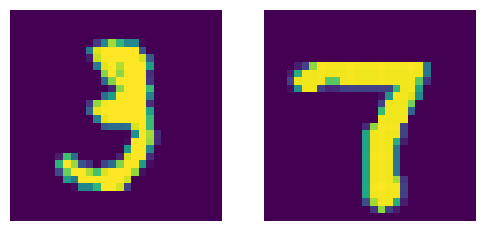

In [5]:
from fastai.data.all import show_images


show_images([threes_tensors[0], seven_tensors[0]])

In [6]:
stacked_threes = torch.stack(threes_tensors).float() / 255
stacked_sevens = torch.stack(seven_tensors).float() / 255

# The length of a tensor.shape is its rank!
# len(stacked_threes.shape) or stacked_threes.ndim
display(stacked_threes.shape, stacked_threes.ndim)

torch.Size([6131, 28, 28])

3

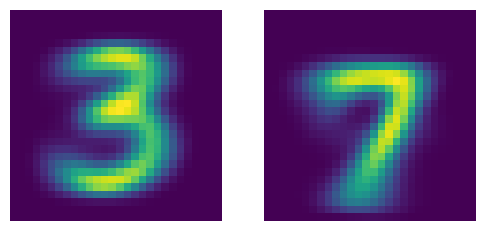

In [7]:
three_mean = stacked_threes.mean(0)
seven_mean = stacked_sevens.mean(0)

show_images([three_mean, seven_mean])

Now we can compute either the Mean-Absolute-Error (MAE or L1 norm) or the Root-Mean-Squared-Error (RMSE or L2 norm) between any given image and the previously computed mean footprint.

In [8]:
mae_three = (stacked_threes[0] - three_mean).abs().mean()
rmse_three = ((stacked_threes[0] - three_mean) ** 2).mean().sqrt()
mae_seven = (stacked_sevens[0] - three_mean).abs().mean()
rmse_seven = ((stacked_sevens[0] - three_mean) ** 2).mean().sqrt()

display(f"MAE_3={mae_three}; MAE_7={mae_seven}")
display(f"RMSE_3={rmse_three}; RMSE_7={rmse_seven}")

'MAE_3=0.10742203146219254; MAE_7=0.1715536266565323'

'RMSE_3=0.19120194017887115; RMSE_7=0.30306190252304077'

Pytorch exposes these as "loss functions" as well:

In [9]:
import torch.nn.functional as F


display(f"MAE_3={F.l1_loss(three_mean, stacked_threes[0])}; MAE_7={F.l1_loss(three_mean, stacked_sevens[0])}")
display(f"RMSE_3={F.mse_loss(three_mean, stacked_threes[0]).sqrt()}; RMSE_7={F.mse_loss(three_mean, stacked_sevens[0]).sqrt()}")

'MAE_3=0.10742203146219254; MAE_7=0.1715536266565323'

'RMSE_3=0.19120194017887115; RMSE_7=0.30306190252304077'

Now, let's extract and build the validation sets to compute the accuracy of the model to see how it performs on unseen data.

In [10]:
validation_threes = torch.stack([torch.tensor(np.array(Image.open(img_path))) for img_path in (path/"valid"/"3").ls()]).float() / 255
validation_sevens = torch.stack([torch.tensor(np.array(Image.open(img_path))) for img_path in (path/"valid"/"7").ls()]).float() / 255

display(validation_threes.shape, validation_sevens.shape)

torch.Size([1010, 28, 28])

torch.Size([1028, 28, 28])

We want to compute the Mean-Absolute-Error between the ideal 3's and 7's using the mean tensors for each and write a `is_3` method to classify any random image based on the smallest difference calculated.

In [11]:
def mnist_distance(a, b):
  return (a - b).abs().mean((-1, -2))


def is_3(img):
  return mnist_distance(img, three_mean) < mnist_distance(img, seven_mean)


is_3(validation_threes[0]), is_3(validation_sevens[0])

(tensor(True), tensor(False))

Now we can compute the accuracy by applying `is_3` to the entire validation set and getting the mean...

In [12]:
accuracy_threes = is_3(validation_threes).float().mean()
accuracy_sevens = (1 - is_3(validation_sevens).float()).mean()

accuracy_threes, accuracy_sevens, (accuracy_threes + accuracy_sevens) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent

Now, we'll transform the images into a format that can be feed into a neural net and trained using Stochastic Gradient Descent.

First, we squash the 28x28 images into rank-2 tensors to have the 784 pixels in single vector sequences for each image. Using the `.view` method we can tell PyTorch to transform the tensor into any shape we want. The `-1` is a special value that tells PyTorch to resize that axis as needed to fit in all the data...

In [13]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)
# We need a label for each image. We'll use 1 for 3's and 0 for 7's.
train_y = torch.tensor(len(stacked_threes) * [1] + len(stacked_sevens) * [0]).unsqueeze(1)

test_x = torch.cat([validation_threes, validation_sevens]).view(-1, 28 * 28)
test_y = torch.tensor(len(validation_threes) * [1] + len(validation_sevens) * [0]).unsqueeze(1)

# The 784 pixels of a single image squashed together into rank-2 (1 dimensional) vector...
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [14]:
train_dataset = list(zip(train_x, train_y))
test_dataset = list(zip(test_x, test_y))

x, y = train_dataset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

Now we need initial random weights for every pixel. This is the "initialize" step in the 7-step ML framework.

In [15]:
def init_params(size, std=1.0):
  return (torch.randn(size) * std).requires_grad_()


weights, bias = init_params((28 * 28, 1)), init_params(1)
weights, bias

(tensor([[-1.3342e-01],
         [-1.0032e+00],
         [ 5.8024e-01],
         [ 2.1513e+00],
         [-2.2431e-01],
         [ 6.8504e-02],
         [ 2.4477e+00],
         [ 1.0298e+00],
         [-9.4101e-02],
         [-1.0351e+00],
         [ 3.5467e-01],
         [-1.1273e+00],
         [-2.9759e-01],
         [ 1.4378e+00],
         [-1.6333e+00],
         [-8.1809e-02],
         [-4.5485e-02],
         [-4.7952e-01],
         [ 1.1198e+00],
         [ 1.2262e+00],
         [-1.1998e-01],
         [-1.4484e+00],
         [-2.7267e-01],
         [ 7.3305e-01],
         [ 1.4455e-01],
         [ 1.9592e-01],
         [-2.7379e-01],
         [ 1.4274e+00],
         [-8.2354e-01],
         [ 2.8821e-01],
         [-8.5173e-01],
         [-8.9788e-01],
         [ 6.9048e-01],
         [ 6.6276e-01],
         [ 1.2878e+00],
         [ 4.1945e-01],
         [-7.5314e-01],
         [ 3.1223e-01],
         [-2.1888e-01],
         [-2.6825e-01],
         [ 1.6084e+00],
         [-4.102

We implement a linear prediction method by multiplying the image vectors against the weights and add a bias.

In [16]:
def linear1(x_batch):
  # @ is the Python symbol to apply the matrix multiplcation operation.
  return x_batch @ weights + bias


preds = linear1(train_x)
preds

tensor([[-2.7733],
        [ 0.1922],
        [ 0.9431],
        ...,
        [-2.2690],
        [ 8.5602],
        [-2.0969]], grad_fn=<AddBackward0>)

Now we have to implement a loss function to establish a performance benchmark the neural net can optimize for... `torch.where(a, b, c)` uses b when `a` is true and `c` when not.

In [17]:
def mnist_loss(preds, targs):
  # When targ == 1, check how far pred is from 1 (if it's 1, the distance then is 0 ... 1 - 1)
  # Else, targ == 0 (if pred == 0, the distance then is 0, 0 - 0)
  preds = preds.sigmoid()
  return torch.where(targs == 1, 1 - preds, preds).mean()

Let's put everything together and recreate the Machine Learning lifecycle of training parameters.

In [18]:
from fastai.data.all import DataLoader, first


# 1. Initialize params and configure objects like datasets.
weights = init_params((28 * 28, 1))
bias = init_params(1)

train_dl = DataLoader(train_dataset, batch_size=256)
test_dl = DataLoader(test_dataset, batch_size=256)
x_batch, y_batch = first(train_dl)

x_batch.shape, y_batch.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [19]:
def calc_grad(x_batch, y_batch, model):
  preds = model(x_batch)
  loss = mnist_loss(preds, y_batch)
  loss.backward()


def train_epoch(model, lr, params):
  for x_batch, y_batch in train_dl:
    calc_grad(x_batch, y_batch, model)
    for p in params:
      p.data -= p.grad * lr
      p.grad.zero_()


def batch_accuracy(x_batch, y_batch):
  preds = x_batch.sigmoid()
  correct = (preds > 0.5) == y_batch
  return correct.float().mean()


def validate_epoch(model):
  accuracies = [batch_accuracy(model(x_batch), y_batch) for x_batch, y_batch in test_dl]
  return round(torch.stack(accuracies).mean().item(), 4)

validate_epoch(linear1)

0.5853

In [20]:
params = (weights, bias)
lr = 0.1

for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1))
  

0.6812
0.7517
0.7977
0.8232
0.8467
0.8658
0.8834
0.8936
0.903
0.9088
0.9177
0.9221
0.9265
0.9319
0.9334
0.9378
0.9387
0.9412
0.9426
0.9436


We can also use the built-in Pytorch implementation for the linear model: `nn.Linear`.

In [21]:
linear_model = torch.nn.Linear(28 * 28, 1)

In [22]:
class BasicOptimizer:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr
  
  def step(self, *args, **kwargs):
    for param in self.params:
      param.data -= param.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for param in self.params:
      param.grad = None


opt = BasicOptimizer(linear_model.parameters(), 0.1)


def train_epoch(model):
  for x_batch, y_batch in train_dl:
    calc_grad(x_batch, y_batch, model)
    opt.step()
    opt.zero_grad()


def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model))
  

train_model(linear_model, 20)

0.5449
0.874
0.935
0.9565
0.9643
0.9638
0.9658
0.9677
0.9687
0.9697
0.9706
0.9716
0.9716
0.9716
0.9716
0.9721
0.9721
0.9716
0.9721
0.9721


But we could also use a built-in fastai optimizer for Stochastic Gradient Descent and get equally impressive results...

In [23]:
from fastai.optimizer import SGD

linear_model = torch.nn.Linear(28 * 28, 1)
opt = SGD(linear_model.parameters(), 0.1)
train_model(linear_model, 20)

0.5366
0.8677
0.9336
0.9521
0.9623
0.9653
0.9653
0.9672
0.9677
0.9697
0.9697
0.9706
0.9711
0.9711
0.9716
0.9716
0.9716
0.9721
0.9721
0.9721


And instead of implementing our own `train_model` method, we can use fastai's `Learner` objects with the `.fit` method... Fastai's learners require a `Dataloaders` object with both training and testing dataloaders to train.

In [24]:
from fastai.data.all import DataLoaders
from fastai.learner import Learner


dls = DataLoaders(train_dl, test_dl)
learner = Learner(dls=dls, model=torch.nn.Linear(28 * 28, 1), loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)

learner.fit(20, lr=0.1)

## Adding nonlinearity

We'll try to replace the linear function we've been using so far for a neural net to gain infinite flexibility.

In [25]:
w1 = init_params((28 * 28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)


def simple_net(x_batch):
  res = x_batch @ w1 + b1
  res = res.max(tensor(0.0))
  res = x_batch @ w2 + b2
  return res


w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 30]), torch.Size([30]), torch.Size([30, 1]), torch.Size([1]))

Or we can use a sequential neural net object from PyTorch.

'batch_accuracy=0.982826292514801'

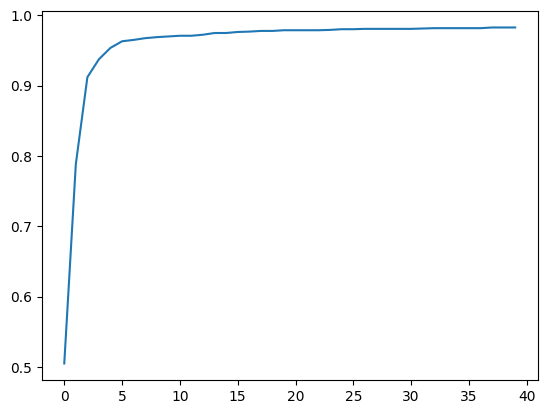

In [26]:
import matplotlib.pyplot as plt
from fastcore.foundation import L


simple_net = torch.nn.Sequential(
  # All these are referred to as "layers"
  torch.nn.Linear(28 * 28, 30), # These are "linear layers"
  torch.nn.ReLU(), # And these ones "nonlinearities" or "activation functions"
  torch.nn.Linear(30, 1),
)
learner = Learner(dls=dls, model=simple_net, loss_func=mnist_loss, opt_func=SGD, metrics=batch_accuracy)
learner.fit(40, 0.1)
display(f"batch_accuracy={learner.recorder.values[-1][2]}")
plt.plot(L(learner.recorder.values).itemgot(2))